In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error

In [4]:
# Load the data
#os.chdir('/home/jovyan')
data = pd.read_csv('Spotify_Dataset_V3.csv', delimiter=';')

# Define ranking categories based on the 'rank' column
def rank_category(rank):
    if rank <= 20:     # Top 50
        return 1
    elif rank >20 and rank <=50:
        return 2
    elif rank >50 and rank <=100:
        return 3
    elif rank >100 and rank <=200:
        return 4
    else:
        return 0      # None, if applicable

# Calculate the highest rank achieved by each song
highest_ranks = data.groupby('id')['Rank'].min().reset_index()
highest_ranks.rename(columns={'Rank': 'Highest Rank'}, inplace=True)

# Merge the highest rank back with the other features
data = highest_ranks.merge(data, on='id', how='left')

In [6]:
### Filter data for 'Artist 1' and drop unnecessary columns
#data = data[data['# of Artist'] == 'Artist 1']

data = data.sort_values(by='Rank', ascending=True)  # Assuming ascending order means highest rank is the first row
data = data.drop_duplicates(subset='Title', keep='first')  # Drop duplicates based on 'Song', keeping the highest rank

data = data.drop(columns=['Highest Rank','id', 'Song URL', '# of Nationality', '# of Artist', 'Title', 'Artists', 'Artist (Ind.)', 'Continent', 'Nationality', 'Points (Ind for each Artist/Nat)', 'Points (Total)', 'Date'])


print(data)

        Rank  Danceability  Energy  Loudness  Speechiness  Acousticness  \
305727     1         0.740   0.613     -4.88        0.145         0.258   
3162       1         0.761   0.525     -6.90        0.094         0.440   
140315     1         0.765   0.523  -4333.00        0.030         0.184   
52332      1         0.336   0.627  -7463.00        0.038         0.164   
560216     1         0.778   0.317 -10732.00        0.334         0.592   
...      ...           ...     ...       ...          ...           ...   
239206   200         0.769   0.455  -5698.00        0.155         0.554   
445348   200         0.802   0.833  -4234.00        0.083         0.008   
157810   200         0.613   0.716  -9365.00        0.026         0.084   
259979   200         0.710   0.814  -4575.00        0.056         0.162   
218875   200         0.667   0.478  -5345.00        0.032         0.200   

        Instrumentalness  Valence  
305727             0.004    0.473  
3162               0.000   

In [8]:
#Apply the ranking category function to the data
data['Rank_Category'] = data['Rank'].apply(rank_category)

<Axes: >

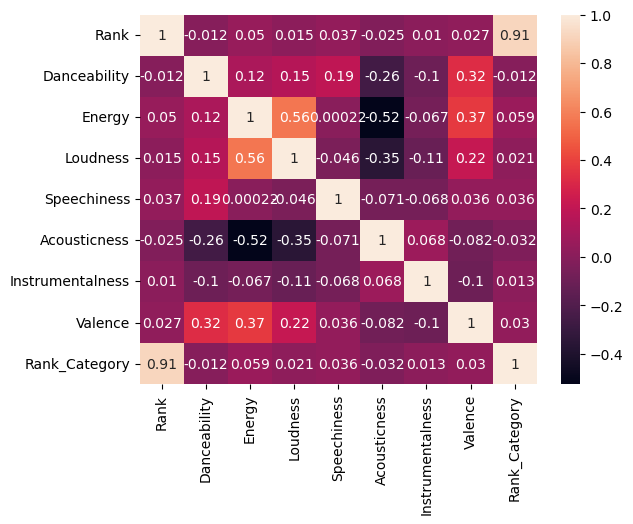

In [10]:
# Check correlation to identify potential data leakage
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True)

In [12]:
x = data.drop(columns=['Rank', 'Rank_Category'])  # Drop rank, date, and target columns
y = data['Rank_Category']

print(x)
# Handle missing values if any
x = x.fillna(x.median())  # For simplicity, fill numeric features with median values

        Danceability  Energy  Loudness  Speechiness  Acousticness  \
305727         0.740   0.613     -4.88        0.145         0.258   
3162           0.761   0.525     -6.90        0.094         0.440   
140315         0.765   0.523  -4333.00        0.030         0.184   
52332          0.336   0.627  -7463.00        0.038         0.164   
560216         0.778   0.317 -10732.00        0.334         0.592   
...              ...     ...       ...          ...           ...   
239206         0.769   0.455  -5698.00        0.155         0.554   
445348         0.802   0.833  -4234.00        0.083         0.008   
157810         0.613   0.716  -9365.00        0.026         0.084   
259979         0.710   0.814  -4575.00        0.056         0.162   
218875         0.667   0.478  -5345.00        0.032         0.200   

        Instrumentalness  Valence  
305727             0.004    0.473  
3162               0.000    0.531  
140315             0.000    0.394  
52332              0.000   

In [14]:
# Convert categorical columns, if any
categorical_cols = x.select_dtypes(include=['object']).columns
x = pd.get_dummies(x, columns=categorical_cols, drop_first=True)

# Split the dataset into training and test sets with stratification
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

# Initialize and tune the Random Forest model
model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, random_state=0)

In [19]:

# Initialize the models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, random_state=0),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=0),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=0),
    'Support Vector Machine': SVC(kernel='linear', random_state=0),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=0)
}

from sklearn.metrics import accuracy_score, classification_report

# Train and evaluate each model
for model_name, model in models.items():
    try:
        # Train the model
        model.fit(x_train, y_train)
        
        # Predict on the test set
        y_pred = model.predict(x_test)
        
        # Print the classification results
        print(f"--- {model_name} ---")
        print("Classification Accuracy on Test Set:", accuracy_score(y_test, y_pred))
        
        # Add zero_division=1 to avoid ill-defined precision/recall for labels with no predicted samples
        print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=1))
        print("="*50)
    
    except Exception as e:
        print(f"An error occurred with {model_name}: {e}")

# Initialize an empty list to store the results
results = []

# Train and evaluate each model
for model_name, model in models.items():
    try:
        # Train the model
        model.fit(x_train, y_train)
        
        # Predict on the test set
        y_pred = model.predict(x_test)
        
        # Accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        # Classification Report
        report = classification_report(y_test, y_pred, zero_division=1, output_dict=True)
        
        # F1-scores for each class
        f1_scores = {f"F1-Score ({label})": score["f1-score"] for label, score in report.items() if isinstance(score, dict)}
        
        # Combine all results into a dictionary
        result = {
            "Model": model_name,
            "Accuracy": accuracy,
        }
        result.update(f1_scores)  # Add F1-scores
        
        # Append to results list
        results.append(result)
    
    except Exception as e:
        print(f"An error occurred with {model_name}: {e}")

# Convert the results to a DataFrame for better visualization
results_df = pd.DataFrame(results)

# Display the results neatly
print(results_df)


--- Random Forest ---
Classification Accuracy on Test Set: 0.38873994638069703

Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       254
           2       0.67      0.02      0.03       246
           3       0.08      0.01      0.01       398
           4       0.39      0.97      0.56       594

    accuracy                           0.39      1492
   macro avg       0.28      0.25      0.15      1492
weighted avg       0.29      0.39      0.23      1492



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--- Logistic Regression ---
Classification Accuracy on Test Set: 0.39745308310991956

Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       254
           2       1.00      0.00      0.00       246
           3       1.00      0.00      0.00       398
           4       0.40      1.00      0.57       594

    accuracy                           0.40      1492
   macro avg       0.60      0.25      0.14      1492
weighted avg       0.59      0.40      0.23      1492

--- K-Nearest Neighbors ---
Classification Accuracy on Test Set: 0.26742627345844505

Classification Report:
               precision    recall  f1-score   support

           1       0.17      0.17      0.17       254
           2       0.12      0.11      0.11       246
           3       0.27      0.29      0.28       398
           4       0.37      0.36      0.36       594

    accuracy                           0.27      1492
   macro avg       

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                    Model  Accuracy  F1-Score (1)  F1-Score (2)  F1-Score (3)  \
0           Random Forest  0.388740      0.000000      0.031746      0.009456   
1     Logistic Regression  0.397453      0.000000      0.000000      0.000000   
2     K-Nearest Neighbors  0.267426      0.167641      0.111828      0.278511   
3       Gradient Boosting  0.388740      0.007117      0.053030      0.086022   
4  Support Vector Machine  0.390080      0.007491      0.015564      0.082251   
5           Decision Tree  0.373324      0.061856      0.118380      0.081967   

   F1-Score (4)  F1-Score (macro avg)  F1-Score (weighted avg)  
0      0.558909              0.150028                 0.230272  
1      0.568825              0.142206                 0.226462  
2      0.364876              0.230714                 0.266538  
3      0.559271              0.176360                 0.255561  
4      0.560561              0.166467                 0.248955  
5      0.540340              0.200636     